## Лабораторна робота №3
* Тема: Нечітка логіка: проєктування інтелектуального модуля.
* Мета лабораторної роботи полягає в ознайомленні студентів із принципами нечіткої логіки та її застосуванням для проєктування інтелектуального модуля, здатного приймати рішення в умовах невизначеності та неповної інформації. Під час виконання роботи студенти навчаться формулювати нечіткі множини, визначати функції залежності, створювати правила нечіткого виведення та реалізовувати систему, що імітує процес прийняття рішень у реальних умовах. Практичний аспект полягає в розробці модуля, який на основі нечітких вхідних даних генерує обґрунтовані вихідні результати, що можуть застосовуватися для інтелектуальних систем керування, рекомендаційних сервісів або пошуку з нечіткою відповідністю.
* Варіант №1
* Виконала студентка групи ОІ-21сп 
* Вишинська Наталія

### Імпорт та встановлення бібліотек 

In [1]:
pip install fuzzywuzzy rapidfuzz python-Levenshtein scikit-fuzzy pandas numpy

In [2]:
pip install jellyfish

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from rapidfuzz import fuzz, distance
import jellyfish
import skfuzzy as fuzz_lib
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from tabulate import tabulate

### Завантаження датасету

In [29]:
# Завантаження датасету
df = pd.read_csv("corner_cases_new.csv", encoding="ISO-8859-1")
print("Перші 5 рядків датасету:")
print(df.head())
 
# Перевіряємо назви колонок
print("\nНазви колонок у датасеті:", df.columns.tolist())

Перші 5 рядків датасету:
                 Name1               Name2
0          Mehul Gupta         Meryl Gupta
1    John Andrew Lewis   Jahn Andrej Levis
2      Cyndi Eric Wood  Candice Erick Waud
3           Mary Ellen          Mari Ehlen
4  Carlos Alfonzo Diaz         Carlow Diez

Назви колонок у датасеті: ['Name1', 'Name2']


### Визначення функцій

In [1]:
def soundex_similarity(name1, name2):
    # Обчислення Soundex схожості (0-1)
    if pd.isna(name1) or pd.isna(name2) or not isinstance(name1, str) or not isinstance(name2, str):
        return 0.0
    s1 = jellyfish.soundex(name1)
    s2 = jellyfish.soundex(name2)
    return 1.0 if s1 == s2 else 0.5

def term_length_category(term):
    # Категоризація довжини терміну
    if pd.isna(term) or not isinstance(term, str):
        return "короткий"
    length = len(term)
    if length <= 5:
        return "короткий"
    elif length <= 15:
        return "середній"
    else:
        return "довгий"

def classic_method(jaro_winkler, soundex_sim, dam_lev):
    # Класичний метод із порогами
    if jaro_winkler >= 0.9 and soundex_sim == 1.0 and dam_lev <= 3:
        return "Належить"
    return "Не належить"

### Додавання метрик до DataFrame

In [6]:
df["Soundex_Similarity"] = df.apply(lambda row: soundex_similarity(row["Name1"], row["Name2"]), axis=1)
df["Length_Name1"] = df["Name1"].apply(term_length_category)
df["Length_Name2"] = df["Name2"].apply(term_length_category)
df["JaroWinkler_Similarity"] = df.apply(
    lambda row: fuzz.WRatio(row["Name1"], row["Name2"]) / 100 if not pd.isna(row["Name1"]) and not pd.isna(row["Name2"]) else 0.0, axis=1
)
df["Damerau_Levenshtein_Distance"] = df.apply(
    lambda row: distance.Levenshtein.distance(str(row["Name1"]), str(row["Name2"])) if not pd.isna(row["Name1"]) and not pd.isna(row["Name2"]) else 0, axis=1
)
print("Метрики додано до датасету!")

Метрики додано до датасету!


### Визначення нечітких змінних і функцій належності

In [7]:
similarity = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'similarity')
phonetic = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'phonetic')
edit_dist = ctrl.Antecedent(np.arange(0, 21, 1), 'edit_dist')
membership = ctrl.Consequent(np.arange(0, 101, 1), 'membership')

similarity['low'] = fuzz_lib.trimf(similarity.universe, [0, 0, 0.5])
similarity['medium'] = fuzz_lib.trimf(similarity.universe, [0.3, 0.6, 0.8])
similarity['high'] = fuzz_lib.trimf(similarity.universe, [0.7, 1, 1])

phonetic['none'] = fuzz_lib.trimf(phonetic.universe, [0, 0, 0.3])
phonetic['partial'] = fuzz_lib.trimf(phonetic.universe, [0.2, 0.5, 0.7])
phonetic['full'] = fuzz_lib.trimf(phonetic.universe, [0.6, 1, 1])

edit_dist['low'] = fuzz_lib.trimf(edit_dist.universe, [0, 0, 5])
edit_dist['medium'] = fuzz_lib.trimf(edit_dist.universe, [3, 7, 12])
edit_dist['high'] = fuzz_lib.trimf(edit_dist.universe, [10, 20, 20])

membership['low'] = fuzz_lib.trimf(membership.universe, [0, 0, 40])
membership['medium'] = fuzz_lib.trimf(membership.universe, [30, 50, 70])
membership['high'] = fuzz_lib.trimf(membership.universe, [60, 100, 100])

print("Нечіткі змінні визначено!")

Нечіткі змінні визначено!


### Визначення правил і системи керування

In [8]:
rule1 = ctrl.Rule(similarity['high'] & phonetic['full'] & edit_dist['low'], membership['high'])
rule2 = ctrl.Rule(similarity['high'] & phonetic['full'] & edit_dist['medium'], membership['high'])
rule3 = ctrl.Rule(similarity['high'] & phonetic['partial'] & edit_dist['low'], membership['high'])
rule4 = ctrl.Rule(similarity['medium'] & phonetic['full'] & edit_dist['low'], membership['high'])
rule5 = ctrl.Rule(similarity['medium'] & phonetic['partial'] & edit_dist['low'], membership['medium'])
rule6 = ctrl.Rule(similarity['medium'] & phonetic['none'] & edit_dist['low'], membership['medium'])
rule7 = ctrl.Rule(similarity['low'] & phonetic['full'] & edit_dist['low'], membership['medium'])
rule8 = ctrl.Rule(similarity['high'] & phonetic['none'] & edit_dist['high'], membership['low'])
rule9 = ctrl.Rule(similarity['medium'] & phonetic['partial'] & edit_dist['high'], membership['low'])
rule10 = ctrl.Rule(similarity['low'] & phonetic['none'] & edit_dist['high'], membership['low'])
rule11 = ctrl.Rule(similarity['low'] & phonetic['partial'] & edit_dist['medium'], membership['low'])
rule12 = ctrl.Rule(similarity['medium'] & phonetic['none'] & edit_dist['high'], membership['low'])

membership_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9, rule10, rule11, rule12])
membership_sim = ctrl.ControlSystemSimulation(membership_ctrl)

print("Правила та система керування налаштовані!")

Правила та система керування налаштовані!


### Обробка даних

In [9]:
fuzzy_results = []
classic_results = []

for index, row in df.iterrows():
    name1, name2 = row["Name1"], row["Name2"]
    jaro_winkler = max(0, min(1, row["JaroWinkler_Similarity"]))
    soundex_sim = max(0, min(1, row["Soundex_Similarity"]))
    dam_lev = max(0, min(20, row["Damerau_Levenshtein_Distance"]))
    
    # Нечітка логіка
    try:
        membership_sim.input['similarity'] = jaro_winkler
        membership_sim.input['phonetic'] = soundex_sim
        membership_sim.input['edit_dist'] = dam_lev
        membership_sim.compute()
        probability = membership_sim.output.get('membership', 0)
    except Exception as e:
        print(f"Помилка для рядка {index} (fuzzy): {e}")
        probability = 0
    
    fuzzy_decision = "Належить" if probability >= 70 else "Не належить"
    
    # Класичний метод
    classic_decision = classic_method(jaro_winkler, soundex_sim, dam_lev)
    
    fuzzy_results.append({
        "Термін 1": name1,
        "Термін 2": name2,
        "Jaro-Winkler": round(jaro_winkler, 2),
        "Soundex": round(soundex_sim, 2),
        "Damerau-Levenshtein": dam_lev,
        "Ймовірність належності": round(probability),
        "Рішення": fuzzy_decision
    })
    
    classic_results.append({
        "Термін 1": name1,
        "Термін 2": name2,
        "Jaro-Winkler": round(jaro_winkler, 2),
        "Soundex": round(soundex_sim, 2),
        "Damerau-Levenshtein": dam_lev,
        "Рішення": classic_decision
    })

print("Обробка даних завершена!")

Обробка даних завершена!


### Виведення результатів

In [71]:
# Перетворюємо дані в DataFrame для fuzzy та класичного методу
fuzzy_df = pd.DataFrame(fuzzy_results)
classic_df = pd.DataFrame(classic_results)

# Додаємо стовпець з класичними рішеннями до таблиці fuzzy
fuzzy_df['Рішення (Classic)'] = classic_df['Рішення']

# Виведення всієї таблиці з результатами
print("Результати нечіткої логіки та класичного методу:")
display(fuzzy_df)  # Використовуємо display для виведення таблиці

# Топ-10 
fuzzy_top_10 = fuzzy_df.sort_values(by="Ймовірність належності", ascending=False).head(10)
print("\nТоп-10 схожих пар:")
display(fuzzy_top_10)  # Використовуємо display для виведення таблиці


Результати нечіткої логіки та класичного методу:


,Термін 1,Термін 2,Jaro-Winkler,Soundex,Damerau-Levenshtein,Ймовірність належності,Рішення,Рішення (Classic)
0,Mehul Gupta,Meryl Gupta,0.82,0.5,2,84,Належить,Не належить
1,John Andrew Lewis,Jahn Andrej Levis,0.82,1.0,3,84,Належить,Не належить
2,Cyndi Eric Wood,Candice Erick Waud,0.73,0.5,6,0,Не належить,Не належить
3,Mary Ellen,Mari Ehlen,0.80,1.0,2,83,Належить,Не належить
4,Carlos Alfonzo Diaz,Carlow Diez,0.70,0.5,10,0,Не належить,Не належить
...,...,...,...,...,...,...,...,...
434,Sameer,Samir,0.67,1.0,3,84,Належить,Не належить
435,Siya,Sia,0.75,1.0,2,82,Належить,Не належить
436,Tara,Tara,0.89,1.0,1,85,Належить,Не належить
437,Uma,Uma,0.86,1.0,1,85,Належить,Не належить



Топ-10 схожих пар:


,Термін 1,Термін 2,Jaro-Winkler,Soundex,Damerau-Levenshtein,Ймовірність належності,Рішення,Рішення (Classic)
170,Ankita Manoj Bhavsar,Ankita Manuj Bhavsar,0.95,1.0,1,86,Належить,Належить
125,Tristan Carlos Scott,Tristan Carls Scott,0.97,1.0,1,86,Належить,Належить
128,Arianna Eric Baker,Adrianna Eric Baker,0.97,0.5,1,86,Належить,Не належить
133,Evelyn Dylan Lewis,Evelyn Dilan Lewis,0.94,1.0,1,86,Належить,Належить
134,Saanchi Aniruddh Soman,Saanchi Aniruddh Solman,0.98,1.0,1,86,Належить,Належить
135,Amelia Brayden Walker,Amelia Brayden Walzer,0.95,1.0,1,86,Належить,Належить
139,Tristan Carlos Scott,Tristan Carlos Shott,0.95,1.0,1,86,Належить,Належить
140,Allison Cameron Green,Allison Cameron Gleen,0.95,1.0,1,86,Належить,Належить
142,Arianna Eric Baker,Arianna Eric Backer,0.97,1.0,1,86,Належить,Належить
144,Adrian Cox,Arian Cox,0.95,0.5,1,86,Належить,Не належить


### Візуалізація функцій належності

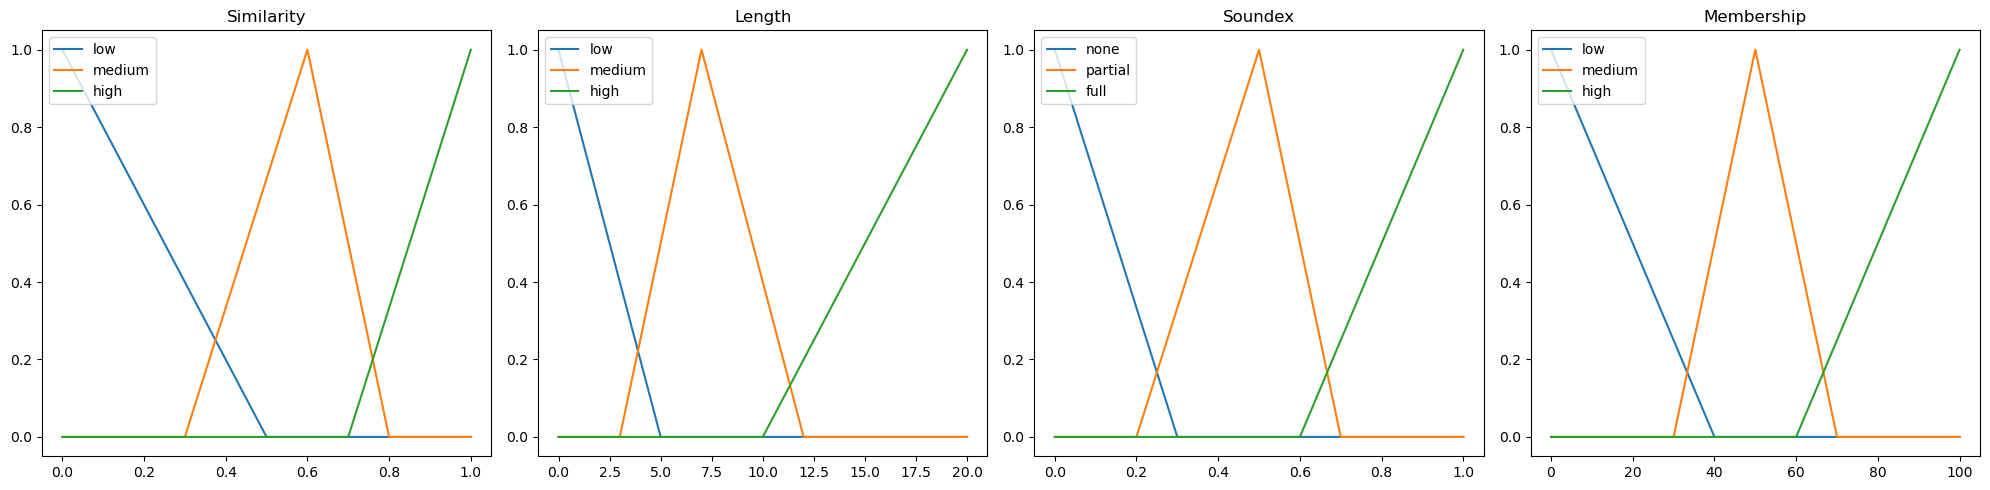

In [66]:
def plot_membership_functions():
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for ax, var, title in zip(
        axes,
        [similarity, edit_dist, phonetic, membership],
        ["Similarity", "Length", "Soundex", "Membership"],
    ):
        for term in var.terms:
            ax.plot(var.universe, var[term].mf, label=term)
        ax.set_title(title)
        ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

plot_membership_functions()

### Порівняння кількості "Належить" і "Не належить"

In [69]:
# Підрахунок кількості рішень для обох методів
fuzzy_counts = fuzzy_df["Рішення"].value_counts().to_dict()
classic_counts = classic_df["Рішення"].value_counts().to_dict()

# Створення таблиці порівняння
comparison_data = [
    ["Належить", fuzzy_counts.get("Належить", 0), classic_counts.get("Належить", 0)],
    ["Не належить", fuzzy_counts.get("Не належить", 0), classic_counts.get("Не належить", 0)]
]

print("\nПорівняння кількості рішень:")
print(tabulate(comparison_data, headers=["Рішення", "Fuzzy", "Classic"], tablefmt="pretty"))


Порівняння кількості рішень:
+-------------+-------+---------+
|   Рішення   | Fuzzy | Classic |
+-------------+-------+---------+
|  Належить   |  393  |   136   |
| Не належить |  46   |   303   |
+-------------+-------+---------+


### Висновок
* В ході виконання лабораторної роботи я ознайомилась з принципами нечіткої логіки та застосувала їх для створення системи визначення схожості імен. Було розроблено інтелектуальний модуль, який аналізує пари імен за трьома метриками: Джаро-Вінклер, Soundex та відстань Дамерау-Левенштейна. Порівняння результатів нечіткої системи з класичним методом показало суттєву різницю в кількості класифікованих пар:

* Нечітка система: 393 пари "Належить", 46 пар "Не належить"
* Класичний метод: 136 пар "Належить", 303 пари "Не належить"
* Ця різниця пояснюється тим, що нечітка логіка дозволяє більш гнучко оцінювати ступінь схожості, враховуючи різні комбінації метрик, а не просто встановлювати чіткі пороги. Аналіз топ-10 найбільш схожих пар показав, що нечітка система присвоює їм високий ступінь ймовірності належності (86%), що вказує на високу впевненість у своїх рішеннях для цих випадків. Таким чином, застосування нечіткої логіки дозволило створити більш гнучку систему, яка краще справляється з задачею визначення схожих імен порівняно з класичним методом.